In [1]:
import pandas as pd
import numpy as np
import warnings

from scipy import stats
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from scipy.special import gamma

from joblib import Parallel, delayed

import datetime
from glob import glob

<AxesSubplot:xlabel='time'>

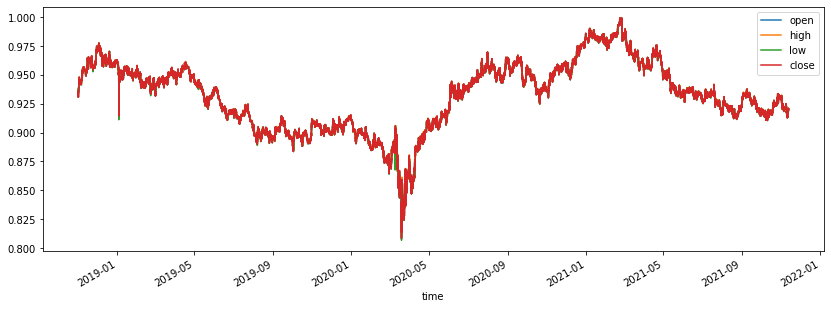

In [2]:
data_path = glob('zip_data/*.csv')[0]
data = pd.read_csv(data_path, index_col=0)
data.index = pd.to_datetime(data.index)
data.plot(figsize=(14,5))

In [3]:
global PositionMoney
PositionMoney = 100_000

def selection_logic(index_data: datetime.date):
    """
    Определяется поведение разбиения данных на период Lookback и Hold
    :param index_data: Подразумевается что сюда приходит день в который планируется работа стратегии
    :return:
    """
    ASIAN_START = datetime.datetime.combine(index_data, datetime.time(hour=22)) #   Начало азиатской сессии
    ASIAN_END = datetime.datetime.combine(index_data + datetime.timedelta(days=1), datetime.time(hour=8))   #   Конец азиатской сессии == Начало английской
    ENGLISH_END = datetime.datetime.combine(index_data + datetime.timedelta(days=1), datetime.time(hour=22))    #   Конец английской сессии
    return ASIAN_END, ASIAN_START, ENGLISH_END


def FX_opening_trade(sampling_data, UpperBorder, LowerBorder, POSITION_MONEY_VOLUME=10):
    """
    Функция проверяет есть ли точки входа на POTENTIAL_HOLD_DATA периоде
    :param sampling_data:
    :param UpperBorder:
    :param LowerBorder:
    :return:

    >>>sampl = pd.Series([.1,0,1,2,4,1,0])
    >>>FX_opening_trade(sampl, 6, .05) # {'logic': None, 'type': None, 'position': None, 'open_time': None}

    >>>sampl = pd.Series([1,2,3,4,5,6,7])
    >>>FX_opening_trade(sampl, 6, .05) # {'logic': True, 'type': 'BUY', 'position': 14285.714285714286, 'open_time': 6}
    """

    #POSITION_MONEY_VOLUME = 10 #   Параметр отвечающий за размер каждой сделки

    answer_template = {'logic': None, 'type': None, 'position': None, 'open_time': None, 'open_price': None}    #   Унифицированный объем шаблона
    for index in sampling_data.index:
        #   Opening Long Order Logic
        if sampling_data.loc[index] > UpperBorder:
            answer_template['logic'] = True
            answer_template['type'] = "BUY"
            answer_template['position'] = abs(POSITION_MONEY_VOLUME / sampling_data.loc[index])
            answer_template['open_time'] = index
            answer_template['open_price'] = sampling_data.loc[index]
            if sampling_data.loc[index] == 0:
                warnings.warn("Zero Division in case zero price in sample. Sample ignored")
                answer_template = {'logic': None, 'type': None, 'position': None, 'open_time': None, 'open_price': None}
            break

        #   Opening Short Order Logic
        if sampling_data.loc[index] < LowerBorder:
            answer_template['logic'] = True
            answer_template['type'] = "SELL"
            answer_template['position'] = abs(POSITION_MONEY_VOLUME / sampling_data.loc[index])
            answer_template['open_time'] = index
            answer_template['open_price'] = sampling_data.loc[index]
            if sampling_data.loc[index] == 0:
                warnings.warn("Zero Division in case zero price in sample. Sample ignored")
                answer_template = {'logic': None, 'type': None, 'position': None, 'open_time': None, 'open_price': None}
            break
    return answer_template

def FX_hold_logic(holding_data, open_list, SLIPADGE, PROFITS_LIST):
    HoldList = {"hold_logic": "END_PERIOD", "close_time": holding_data.index[-1], "close_price": holding_data.loc[holding_data.index[-1]]}
    # Фактически тут прописывается логика будет ли досрочное закрытие позиции
    operation_type = open_list['type']
    position = open_list['position']
    start_price = open_list['open_price']
    SlipadgePPos = SLIPADGE / (start_price * position)

    BUY_TP = PROFITS_LIST["BUY"]["profit"]
    BUY_SL = PROFITS_LIST["BUY"]["loss"]

    SELL_TP = PROFITS_LIST["SELL"]["profit"]
    SELL_SL = PROFITS_LIST["SELL"]["loss"]
    #   Если за время периода владения активом/обязательством произойдут события описанные ниже - досрочно выходим из сделки
    for index in holding_data.index:
        if operation_type == "BUY":
            if (holding_data.loc[index] / start_price) - 1 > BUY_TP + SlipadgePPos:
                HoldList["hold_logic"] = "TAKE_PROFIT"
                HoldList["close_time"] = index
                HoldList["close_price"] = holding_data.loc[index]
                break

            if (holding_data.loc[index] / start_price) - 1 < -1 * (BUY_SL + SlipadgePPos):
                HoldList["hold_logic"] = "STOP_LOSS"
                HoldList["close_time"] = index
                HoldList["close_price"] = holding_data.loc[index]
                break

        if operation_type == "SELL":
            if (start_price / holding_data.loc[index]) - 1 > SELL_TP + SlipadgePPos:
                HoldList["hold_logic"] = "TAKE_PROFIT"
                HoldList["close_time"] = index
                HoldList["close_price"] = holding_data.loc[index]
                break
            if (start_price / holding_data.loc[index]) - 1 < -1 * (SELL_SL + SlipadgePPos):
                HoldList["hold_logic"] = "STOP_LOSS"
                HoldList["close_time"] = index
                HoldList["close_price"] = holding_data.loc[index]
                break

    return HoldList



def CalculateReturn(OrderList, HoldList, SLIPADGE, POSITION_MONEY_VOLUME):
    """
    Тут прописывается логика расчета
    :param OrderList:
    :param HoldList:
    :param SLIPADGE:
    :return:
    """
    if OrderList["type"] == "BUY":
        ret = OrderList["position"] * (HoldList["close_price"] - OrderList["open_price"]) - SLIPADGE
        own_time = HoldList["close_time"] - OrderList["open_time"]

    elif OrderList["type"] == "SELL":
        ret = POSITION_MONEY_VOLUME - OrderList["position"] * HoldList["close_price"] - SLIPADGE
        own_time = HoldList["close_time"] - OrderList["open_time"]
    else:
        warnings.warn("Something goes wrong while calculation of return")
        ret = None
        own_time = None
    return {"Operation Return": ret, "Operation Owning Time": own_time}


def buying_trigger(sampling_data: pd.Series, median_dot: datetime.datetime, SLIPADGE=10, POSITION_MONEY_VOLUME=100):
    """
    Выполняет роль центрального узла связывающего все элементы выполнения стратегии. Планируется что передаются данные полученные из функции предобработки
    FIXME Нужно учитывать что открыть дробную позицию нельзя. Поэтому нужно оставлять параметр FREE CASH
    :param sampling_data:
    :param median_dot:
    :param SLIPADGE:
    :return:
    """
    #   sampling_data = pd.Series([10,10,10,8,6,20,10,9])
    #   media_dot= 2
    UpperBorder = sampling_data.loc[:median_dot].max()  #   Определение верхней границы
    LowerBorder = sampling_data.loc[:median_dot].min()  #   Определение нижней границы
    HoldPeriod = sampling_data.loc[median_dot:] #   Период в течении которого будем пытаться делать ордер

    GetOrderFilter = FX_opening_trade(HoldPeriod, UpperBorder=UpperBorder, LowerBorder=LowerBorder, POSITION_MONEY_VOLUME=POSITION_MONEY_VOLUME)
    #   print(GetOrderFilter)   {'logic': True, 'type': 'SELL', 'position': 12.5, 'open_time': 3, 'open_price': 8}
    if not GetOrderFilter['logic']:
        return None

    #   Если нашлась точка входа то продолжаем выполнение
    if GetOrderFilter['logic']:
        operation_type = GetOrderFilter['type']
        position = GetOrderFilter['position']
        open_time = GetOrderFilter['open_time']
        holding_period_data = sampling_data.loc[open_time:] #   Период на котором выполняются условия владения активов/обязательством

        HoldingResultList = FX_hold_logic(holding_data=holding_period_data, open_list=GetOrderFilter,
                                          SLIPADGE=SLIPADGE,
                                          PROFITS_LIST={
                                          "BUY":{
                                              "profit":.01,
                                              "loss":.01,
                                          },
                                          "SELL":{
                                              "profit":.01,
                                              "loss":.01,
                                          }
                                          })
        #   print(HoldingResultList)    {'hold_logic': 'TAKE_PROFIT', 'close_time': 4, 'close_price': 6}
        HoldProfit = CalculateReturn(GetOrderFilter, HoldList=HoldingResultList,
                                     POSITION_MONEY_VOLUME=POSITION_MONEY_VOLUME,SLIPADGE=SLIPADGE)
        #   print(HoldProfit)   {'Operation Return': 15.0, 'Operation Owning Time': 1}
        TotalList = {'logic': GetOrderFilter['logic'],
                     'operation_type': GetOrderFilter['type'],
                     'operation_position': GetOrderFilter['position'],
                     'position_open_time': GetOrderFilter['open_time'],
                     'open_price': GetOrderFilter['open_price'],
                     'holding_logic': HoldingResultList['hold_logic'],
                     'position_close_time': HoldingResultList['close_time'],
                     'position_close_price': HoldingResultList['close_price'],
                     'operation_money_return': HoldProfit['Operation Return'],
                     'position_holding_time': HoldProfit['Operation Owning Time']}
        #   print(TotalList)   {'logic': True, 'operation_type': 'SELL', 'operation_position': 12.5, 'position_open_time': 3, 'open_price': 8, 'holding_logic': 'TAKE_PROFIT', 'position_close_time': 4, 'position_close_price': 6, 'operation_money_return': 15.0, 'position_holding_time': 1}
        return TotalList

#sampl = pd.Series([10,10,10,8,6,20,10,9])
#print(sampl)
#buying_trigger(sampl, 2)

In [4]:
FX_data = pd.read_csv('zip_data/EURGBP.csv', index_col=0)
FX_data.index = pd.to_datetime(FX_data.index)
FX_data

,open,high,low,close
time,,,,
2018-11-01 00:15:00,0.886545,0.886755,0.886035,0.886205
2018-11-01 00:16:00,0.886205,0.886285,0.886205,0.886240
2018-11-01 00:17:00,0.886240,0.886245,0.886240,0.886245
2018-11-01 00:18:00,0.886245,0.886265,0.886240,0.886265
2018-11-01 00:19:00,0.886265,0.886270,0.886265,0.886270
...,...,...,...,...
2021-11-13 00:55:00,0.853130,0.853170,0.853110,0.853120
2021-11-13 00:56:00,0.853120,0.853160,0.853085,0.853120
2021-11-13 00:57:00,0.853120,0.853120,0.853030,0.853050


  0%|          | 0/840 [00:00<?, ?it/s]

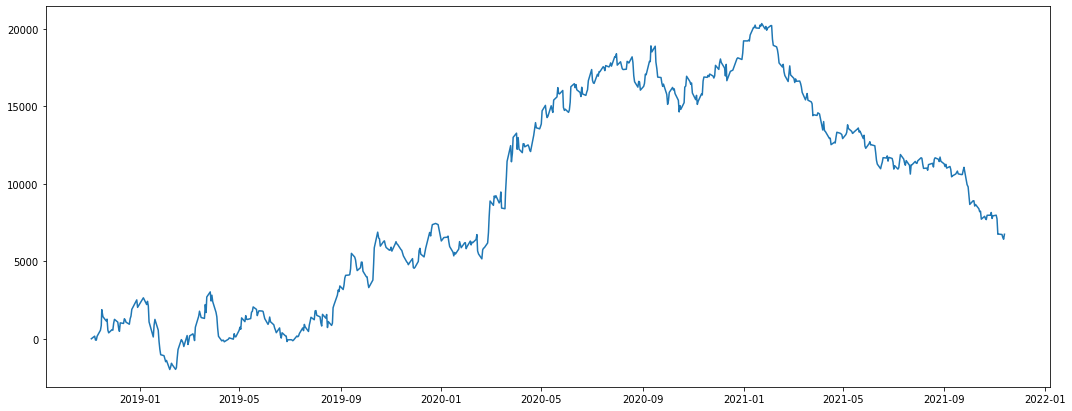

,logic,operation_type,operation_position,position_open_time,open_price,holding_logic,position_close_time,position_close_price,operation_money_return,position_holding_time
0,True,BUY,113860.202443,2018-11-02 08:42:00,0.878270,END_PERIOD,2018-11-02 22:00:00,0.878345,-1.460485,0 days 13:18:00
1,True,SELL,114545.569091,2018-11-06 11:04:00,0.873015,END_PERIOD,2018-11-06 22:00:00,0.871455,168.691088,0 days 10:56:00
2,True,BUY,114462.968368,2018-11-07 13:39:00,0.873645,END_PERIOD,2018-11-07 22:00:00,0.871545,-250.372234,0 days 08:21:00
3,True,SELL,114898.946377,2018-11-08 08:31:00,0.870330,END_PERIOD,2018-11-08 22:00:00,0.870320,-8.851011,0 days 13:29:00
4,True,BUY,114803.313224,2018-11-09 10:10:00,0.871055,END_PERIOD,2018-11-09 22:00:00,0.873375,256.343687,0 days 11:50:00
...,...,...,...,...,...,...,...,...,...,...
610,True,BUY,116750.824553,2021-11-05 10:18:00,0.856525,END_PERIOD,2021-11-05 22:00:00,0.856715,12.182657,0 days 11:42:00
611,True,BUY,116946.754143,2021-11-09 09:52:00,0.855090,END_PERIOD,2021-11-09 22:00:00,0.854950,-26.372546,0 days 12:08:00
612,True,SELL,117071.343277,2021-11-10 09:45:00,0.854180,END_PERIOD,2021-11-10 22:00:00,0.855710,-189.119155,0 days 12:15:00
613,True,SELL,116883.192781,2021-11-11 08:45:00,0.855555,END_PERIOD,2021-11-11 22:00:00,0.856480,-118.116953,0 days 13:15:00


In [5]:
def start_strategy(raw_data):
    TOTAL_PNL = [0]
    TRADE_DATES = list()
    SaveDicts = list()
    #   Итерируемся по всем уникальным дням в данных
    for correct_day in tqdm(np.unique(FX_data.index.date)[:]):
        Asian_end, Asian_start, Engilsh_end = selection_logic(correct_day)
        #   Проверяем, находятся ли нужные индексы в сырых данных
        if (Asian_end in raw_data.index) and (Asian_start in raw_data.index) and (Engilsh_end in raw_data.index):
            sampling_data = raw_data.loc[Asian_start:Engilsh_end].open
            result = buying_trigger(sampling_data=sampling_data, median_dot=Asian_end, SLIPADGE=10, POSITION_MONEY_VOLUME=PositionMoney)
            if result:
                TOTAL_PNL.append(TOTAL_PNL[-1] + result['operation_money_return'])
                #if TOTAL_PNL[-1] < 0:
                #    TOTAL_PNL[-1] = 0
                TRADE_DATES.append(result['position_close_time'])
                SaveDicts.append(result)
    TOTAL_PNL = TOTAL_PNL[1:]
    return TOTAL_PNL, TRADE_DATES, SaveDicts

TOTAL_PNL, TRADE_DATES, SaveDicts = start_strategy(raw_data=FX_data)
plt.figure(figsize=(18,7))
plt.plot(TRADE_DATES, TOTAL_PNL)
plt.show()
df = pd.DataFrame(SaveDicts)
df

In [6]:

df[df.holding_logic == "STOP_LOSS"]

,logic,operation_type,operation_position,position_open_time,open_price,holding_logic,position_close_time,position_close_price,operation_money_return,position_holding_time
35,True,BUY,110656.191214,2019-01-11 10:14:00,0.903700,STOP_LOSS,2019-01-11 19:14:00,0.894500,-1028.036959,0 days 09:00:00
229,True,BUY,116981.639732,2019-12-31 10:31:00,0.854835,STOP_LOSS,2019-12-31 19:37:00,0.845900,-1055.230951,0 days 09:06:00
253,True,BUY,119122.070342,2020-02-13 08:28:00,0.839475,STOP_LOSS,2020-02-13 18:16:00,0.830705,-1054.700557,0 days 09:48:00
270,True,SELL,112707.805015,2020-03-13 11:17:00,0.887250,STOP_LOSS,2020-03-13 19:58:00,0.896390,-1040.149338,0 days 08:41:00
276,True,SELL,109397.221311,2020-03-25 08:10:00,0.914100,STOP_LOSS,2020-03-25 17:48:00,0.923505,-1038.880866,0 days 09:38:00
280,True,BUY,112270.617095,2020-04-01 08:08:00,0.890705,STOP_LOSS,2020-04-01 16:10:00,0.881540,-1038.960206,0 days 08:02:00
312,True,SELL,112438.510190,2020-05-27 08:11:00,0.889375,STOP_LOSS,2020-05-27 17:22:00,0.899015,-1093.907238,0 days 09:11:00
376,True,BUY,108735.245986,2020-09-16 10:09:00,0.919665,STOP_LOSS,2020-09-16 17:40:00,0.910345,-1023.412493,0 days 07:31:00
426,True,SELL,109619.073719,2020-12-11 10:31:00,0.912250,STOP_LOSS,2020-12-11 16:05:00,0.921770,-1053.573582,0 days 05:34:00
487,True,SELL,117797.423770,2021-04-06 08:16:00,0.848915,STOP_LOSS,2021-04-06 19:51:00,0.857615,-1034.837587,0 days 11:35:00


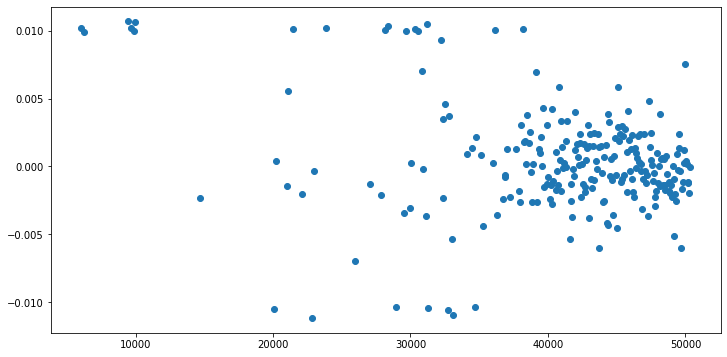

In [10]:
plt.figure(figsize=(12,6))
markdown = df.groupby(by='position_holding_time').mean() / PositionMoney
#markdown.index = pd.to_timedelta(markdown.index)



plt.plot(markdown.index.total_seconds(), markdown.operation_money_return, 'o')